In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

Load the cats vs dogs dataset

In [4]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'], #split the dataset into train, validation and test set
    with_info = True,
    as_supervised = True
)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteATWIWF/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


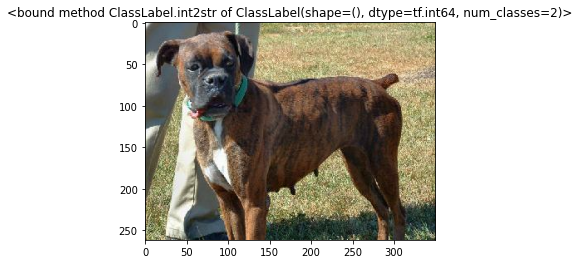

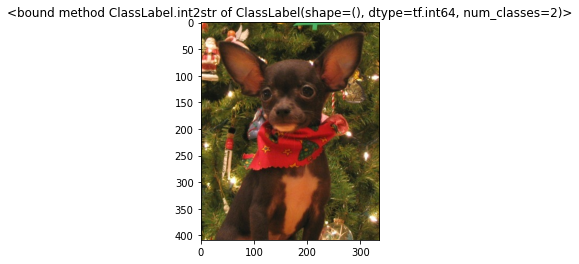

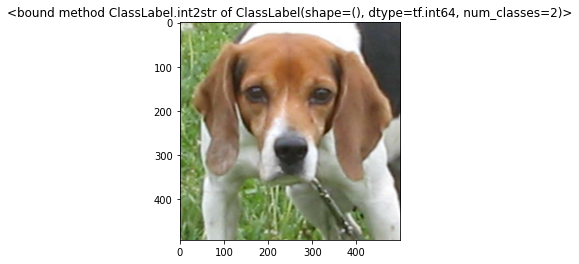

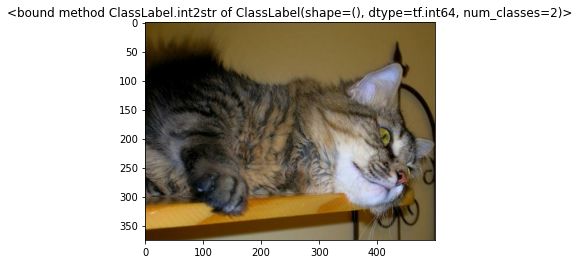

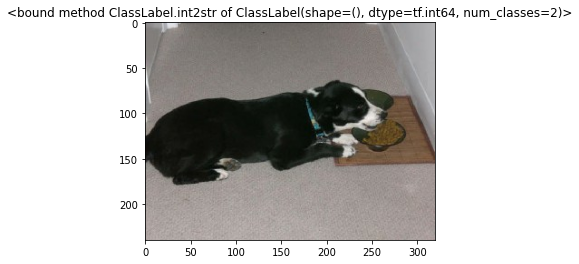

In [6]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name)

In [7]:
IMG_SIZE = 160

def format_example(image, label):

  "returns an image that is reshaped to IMG_SIZE"

  image = tf.cast(image, tf.float32)
  image = (image/127.5) -1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [8]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

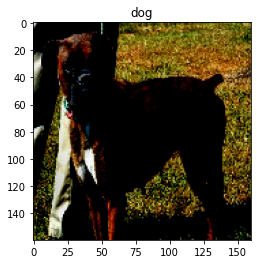

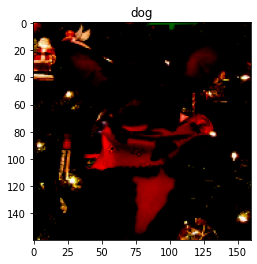

In [9]:
for image, label in train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [10]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [11]:
#Inspect the shape of the original image and the new image to comfirm changes.

for img, label in raw_train.take(2):
  print("Original shape: ", img.shape)

for img, label in train.take(2):
  print("New shape: ", img.shape)

Original shape:  (262, 350, 3)
Original shape:  (409, 336, 3)
New shape:  (160, 160, 3)
New shape:  (160, 160, 3)


In [14]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top = False, #False because we'll be retraining part of the classifier which was built for 1000 classes.
                                               weights = 'imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

The output of the base_model has a shape of (32, 5, 5, 1280) from the features of the original image loaded into it (1, 160, 160, 3). 32 layers of different filters, 1280 channels.

In [17]:
for image, _ in train_batches.take(1):
  pass

feature_batch = base_model(image)
print(feature_batch.shape)

(32, 5, 5, 1280)


Freezing the Base_Model

It is turning the trainable aspect of the layer off.

In [20]:
base_model.trainable = False

Adding the Classifier by adding a global average pooling

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [22]:
prediction_layer = tf.keras.layers.Dense(1)

In [23]:
model = tf.keras.Sequential([base_model, 
                             global_average_layer, 
                             prediction_layer])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


It's time to train the Model

In [25]:
base_learning_rate = 0.0001

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [28]:
initial_epochs = 3
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 14s 658ms/step - loss: 0.8123 - accuracy: 0.4797


In [30]:
history = model.fit(train_batches, epochs = initial_epochs, validation_data = validation_batches)

Epoch 1/3
582/582 [==============================] - 332s 567ms/step - loss: 0.0529 - accuracy: 0.9801 - val_loss: 0.0538 - val_accuracy: 0.9781
Epoch 2/3
582/582 [==============================] - 319s 545ms/step - loss: 0.0492 - accuracy: 0.9816 - val_loss: 0.0514 - val_accuracy: 0.9798
Epoch 3/3
582/582 [==============================] - 319s 544ms/step - loss: 0.0468 - accuracy: 0.9826 - val_loss: 0.0497 - val_accuracy: 0.9798


In [ ]:
model.save("dogs_v_cats.h5")
new_model = tf.keras.model.load_model('dogs_v_cats.h5')

In [31]:
model.predict(test_batches, batch_size = 32 )

array([[-7.1226997],
       [ 2.0492814],
       [ 4.350184 ],
       ...,
       [-7.890901 ],
       [ 5.446426 ],
       [-7.9117427]], dtype=float32)